In [177]:
import os
import cv2
import json
import argparse
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [178]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchsummary
from torch.optim import Adam
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, random_split
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 13.9 MB/s eta 0:00:00


In [5]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00


In [6]:
import captum
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Utils

In [179]:
# these are the mean and std of the data per channel
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class_dict = {2: 'MALIGNANT_Mass',
              1: 'BENIGN_Mass',
              0: 'BACKGROUND'}

def denormalize(tensor):
    tensor = tensor*std + mean
    return tensor

# function for viewling image
def get_rgb_img(img):
    # arrange channels
    img = img.numpy().transpose((1,2,0))

    # use mean and std values
    img = denormalize(img)

    # clip values and view image
    rgb_img = np.clip(img,0,1)

    return np.float32(rgb_img)

def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)

    normalized_img = (img - min_val) / (max_val - min_val)
    normalized_img *= 255
    return normalized_img.astype(int)

def load_parameters(json_file):
    try:
        with open(json_file, 'r') as file:
            parameters = json.load(file)
        return parameters
    except FileNotFoundError:
        print(f"Error: JSON file '{json_file}' not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: JSON file '{json_file}' is not a valid JSON file.")
        return None


class TrainedModel(nn.Module):
    def __init__(self, model_arc_path, model_weights_path, name):
        super(TrainedModel, self).__init__()
        self.model = torch.load(model_arc_path)
        self.model.load_state_dict(torch.load(model_weights_path))
        self.name = name

    def forward(self, x):
        return self.model(x)

# custom dataset which also returns name of the image
class CustomTestDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        rgb_image = image.convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            rgb_image = self.transform(rgb_image)
        if self.target_transform:
            label = self.target_transform(label)
        return rgb_image, int(label), img_name

def get_test_dataloaders(image_folder_path, annotations_file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
        ])


    # create two datsets, one with original size and one resized
    ddsm_test = CustomTestDataset(image_folder_path, annotations_file_path,
                                          transform=transform)

    dataloader_test = DataLoader(ddsm_test, batch_size=1, num_workers=2)
    return dataloader_test

def find_corresponding_mask(directory, image_name):
    # Construct the full path to the image
    image_path = os.path.join(directory, image_name)

    # Check if the image file exists
    if os.path.exists(image_path):
        # Read the image using cv2
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was successfully read
        if image is not None:
            return image
        else:
            print(f"Error: Unable to read image '{image_name}'.")
            return None
    else:
        print(f"Error: Image '{image_name}' not found in the specified directory.")
        return None

def find_corresponding_image(directory, image_name):
    # Construct the full path to the image
    image_path = os.path.join(directory, image_name)

    # Check if the image file exists
    if os.path.exists(image_path):
        # Read the image using cv2
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Check if the image was successfully read
        if image is not None:
            return image
        else:
            print(f"Error: Unable to read image '{image_name}'.")
            return None
    else:
        print(f"Error: Image '{image_name}' not found in the specified directory.")
        return None

def save_1_3_plot(original_img, heatmap, binary_mask, name, dst_folder):
    # resize mask if necessary
    if original_img.shape[:2] != binary_mask.shape[:2]:
        binary_mask = cv2.resize(np.uint8(binary_mask), (original_img.shape[:2][1],original_img.shape[:2][0]),
                                  interpolation=cv2.INTER_LANCZOS4)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    images = [original_img, heatmap, binary_mask]
    titles = ["Original Image", "Heatmap", "Ground Truth"]

    for ax, image, title in zip(axes, images, titles):
        if title == "Ground Truth":
            ax.imshow(image, cmap = 'gray')
        else:
            ax.imshow(image)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    img_path = os.path.join(dst_folder, name)
    plt.savefig(img_path)


## Attribution map functions

In [180]:
# returns heatmap overlayed on the original image
def get_attention_map(model, x, x_fullsize, layer, alpha):

    model.to(device)
    x = x.to(device)
    model.eval()

    # convert data to tensor dimension
    input_img = x.unsqueeze(0)
    output = F.softmax(model(input_img), dim = 1)

    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()

    # get grad cam results
    layer_gradcam = LayerGradCam(model, model.features[layer])

    # this is the heatmap for the original feature map
    attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)
    attributions_lgc = attributions_lgc.squeeze(1).cpu().permute(1,2,0).detach().numpy()

    # overlay heatmap over rgb image
    rgb_image = np.uint8(normalize_image(x_fullsize))
    heatmap_arr = np.uint8(normalize_image(attributions_lgc))

    # Resize heatmap if sizes are different
    if rgb_image.shape[:2] != heatmap_arr.shape[:2]:
        resized_heatmap = cv2.resize(heatmap_arr, (rgb_image.shape[:2][1],rgb_image.shape[:2][0]), interpolation=cv2.INTER_LANCZOS4)

    # Apply colormap to heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(resized_heatmap), cv2.COLORMAP_JET)

    overlaid_image = normalize_image((1-alpha)*rgb_image + alpha*heatmap_colored)

    return overlaid_image, pred_label_idx

### main

In [181]:
def main(model_name, model_path, images_dir, masks_dir, annotations_file, dest_folder, layer_number):

    # load model
    model = models.vgg16(weights='DEFAULT')

    # create dataloader
    dataloader_norm = get_test_dataloaders(images_dir, annotations_file)

    # create destination folder
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # for each test image, get prediction, if the prediction was correct and heatmap
    for image, label, img_name in dataloader_norm:

        # get corresponding mask and heatmap
        mask = find_corresponding_mask(masks_dir, img_name[0])
        rgb_img = find_corresponding_image(images_dir, img_name[0])

        if mask is not None:
            heatmap, y_pred = get_attention_map(model, image[0], rgb_img, layer_number, 0.3)

            # create path according to prediction
            true_class_label = class_dict[int(label[0].item())]

            if true_class_label == 'MALIGNANT_Mass':  # if true label is malignant
                if label[0].item() == y_pred:
                    dest_path = os.path.join(dest_folder, true_class_label, 'true_positive')
                else:
                    dest_path = os.path.join(dest_folder, true_class_label, 'false_negative')
            elif true_class_label == 'BENIGN_Mass':
                if label[0].item() == y_pred:
                    dest_path = os.path.join(dest_folder, true_class_label, 'true_negative')
                else:
                    dest_path = os.path.join(dest_folder, true_class_label, 'false_positive')

            # create directory if it doesnt exist
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)

            ''
            # get the 1x3 plot
            save_1_3_plot(rgb_img, heatmap, mask, img_name[0], dest_folder)
            return img_name[0], true_class_label


### provide paths

In [182]:
model_name = 'vgg16'
conv_layer_number = 29
model_path = '/content/drive/MyDrive/Colab Notebooks/patch_classifier_checkpoints/resner34/64/finetune/0.001/checkpoints/epoch=29-step=2970.ckpt'
images_dir = '/content/drive/MyDrive/Colab Notebooks/Data/attrib_test_data/images'
masks_dir = '/content/drive/MyDrive/Colab Notebooks/Data/attrib_test_data/masks'
annotations_file = '/content/drive/MyDrive/Colab Notebooks/Data/attrib_test_data/annotations_no_zero.csv'
dest_folder = '/content/drive/MyDrive/Colab Notebooks/Data/saved_heatmaps'

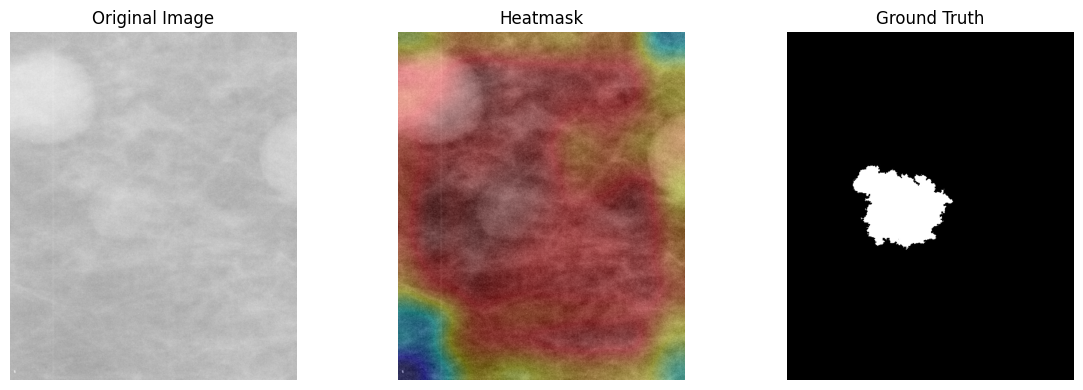

In [183]:
img_name, true_class_label = main(model_name, model_path, images_dir, masks_dir, annotations_file, dest_folder, conv_layer_number)